In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import os

### Explanation of the Data

###### Sample rate = 200 Hz

###### Recording length / sample = 2 sec

###### data points per sample = 400

###### 4 different channels

In [2]:
train_df = pd.read_csv("../resources/full_dataset.csv")

In [3]:
train_df.describe()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p1590,p1591,p1592,p1593,p1594,p1595,p1596,p1597,p1598,p1599
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.140810,-0.302950,0.010370,-0.315550,-0.246540,-0.327840,-0.069840,-0.288940,-0.14932,-0.105610,...,-0.549220,-0.192580,-0.380120,-0.450660,-0.360920,-0.07996,-0.087510,-0.196530,-0.067990,-0.210040
std,11.228007,9.248075,8.044001,10.538612,10.948159,9.033487,8.133558,10.015233,11.30911,9.452679,...,7.511861,10.489023,10.573916,9.035586,7.813691,10.61604,10.757528,9.092647,7.750907,10.730933
min,-74.790000,-54.710000,-60.290000,-39.530000,-80.660000,-65.280000,-69.520000,-51.240000,-73.25000,-64.600000,...,-44.290000,-56.080000,-88.640000,-70.990000,-55.240000,-46.96000,-75.720000,-56.700000,-45.200000,-50.620000
25%,-4.685000,-4.262500,-3.752500,-5.782500,-4.272500,-4.292500,-3.482500,-5.497500,-4.43000,-4.280000,...,-4.557500,-5.470000,-4.542500,-4.600000,-4.172500,-5.31250,-4.550000,-4.030000,-4.002500,-6.070000
50%,-0.075000,-0.100000,-0.085000,-0.450000,-0.080000,-0.175000,-0.125000,-0.345000,-0.23500,-0.045000,...,-0.240000,-0.055000,-0.050000,-0.350000,-0.285000,0.00000,0.030000,-0.160000,0.030000,-0.185000
75%,4.420000,3.835000,3.692500,5.372500,4.320000,3.982500,3.800000,4.890000,4.43000,3.900000,...,3.500000,5.290000,4.277500,3.780000,3.602500,5.28750,4.782500,4.105000,3.622500,5.525000
max,133.990000,102.240000,74.700000,66.840000,101.930000,66.120000,54.620000,48.790000,134.69000,100.280000,...,52.740000,47.620000,79.170000,69.390000,47.720000,49.33000,124.920000,100.330000,72.790000,43.400000


In [4]:
train_df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p1591,p1592,p1593,p1594,p1595,p1596,p1597,p1598,p1599,labels
0,-1.49,-2.95,-0.02,-6.58,-4.96,-4.68,-5.86,-5.47,-4.91,-3.57,...,3.63,3.40,2.27,1.22,9.03,3.61,4.01,2.40,6.29,Lights-on
1,2.74,1.97,-1.18,0.93,2.53,1.63,0.04,0.69,1.15,-1.77,...,2.27,-15.96,-18.23,-14.44,-14.53,-34.16,-25.95,-19.35,-25.20,Lights-on
2,4.57,4.20,5.65,6.70,3.50,1.81,2.91,-4.59,0.70,-2.87,...,-9.25,-4.54,3.08,2.63,-8.10,-2.22,10.23,2.66,-10.61,Lights-on
3,-8.78,-7.27,-5.76,0.32,0.27,-2.67,-1.30,5.96,9.92,7.05,...,22.36,11.73,2.64,-2.93,14.32,0.59,-3.00,-6.58,3.23,Lights-on
4,2.80,-0.98,4.37,1.53,1.40,-1.81,-0.35,-5.31,3.85,-0.31,...,-8.92,-0.24,3.78,8.17,4.24,2.78,-2.62,10.56,2.10,Lights-on


In [5]:
labels = train_df["labels"]
train_df.drop(labels="labels", inplace=True, axis='columns')
features = train_df

In [6]:
labels.describe()

count          1000
unique            2
top       Lights-on
freq            500
Name: labels, dtype: object

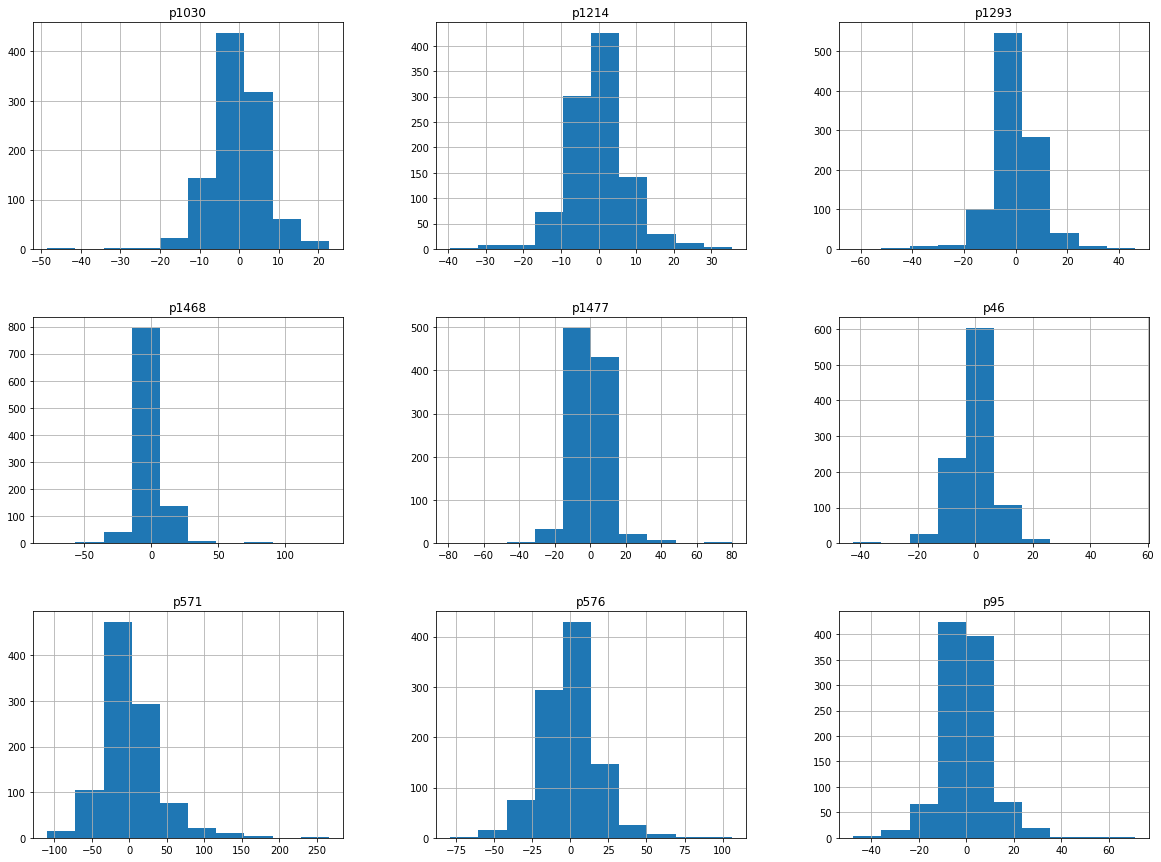

In [7]:
columns = []
for i in range(1600):
    columns.append("p{}".format(i))
features.hist(column=random.sample(columns, 9), figsize=(20, 15));

In [17]:
def plot_random_spectrogram(features, labels=None, fs=200, window=('tukey', 0.25), nperseg=50, noverlap=None):
    features = features.values.reshape(-1, 400, 4)
    start = 0
    end = 999
    if (labels == 1): # show only Lights-on
        end = 499
    elif (labels == 2): # show only Turn-off
        start = 500
    ex_nb = random.randint(0, 999)
    example = features[ex_nb]
    print("picture {}".format(ex_nb))
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
    ax1.plot(example[:, 0])
    freq, times, spec = signal.spectrogram(example[:, 0], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    print("spectrogram shape {}".format(spec.shape))
    ax2.pcolormesh(spec, cmap="Blues")
    
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
    ax1.plot(example[:, 1])
    freq, times, spec = signal.spectrogram(example[:, 1], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    ax2.pcolormesh(spec, cmap="Blues")
    
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
    ax1.plot(example[:, 2])
    freq, times, spec = signal.spectrogram(example[:, 2], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    ax2.pcolormesh(spec, cmap="Blues")
    
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
    ax1.plot(example[:, 3])
    freq, times, spec = signal.spectrogram(example[:, 3], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    ax2.pcolormesh(spec, cmap="Blues")

picture 424
spectrogram shape (26, 8)


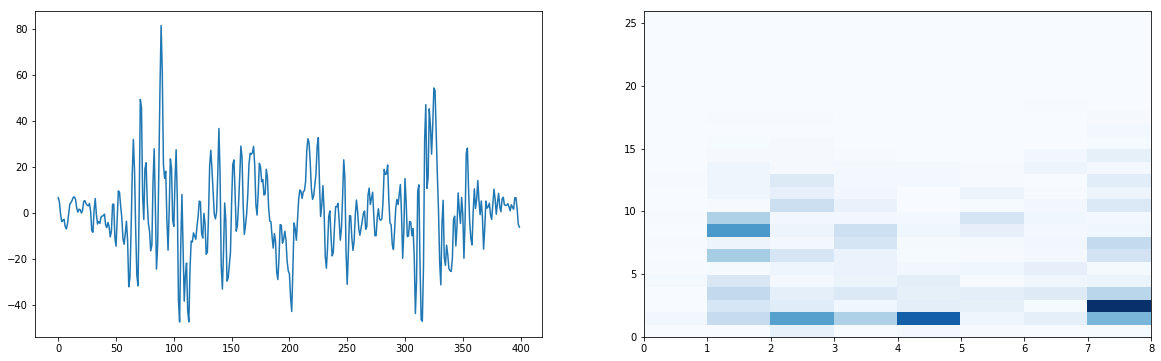

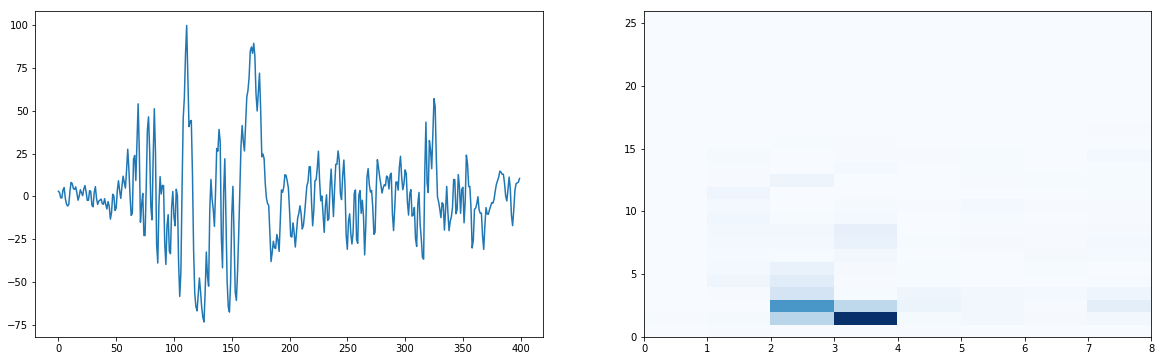

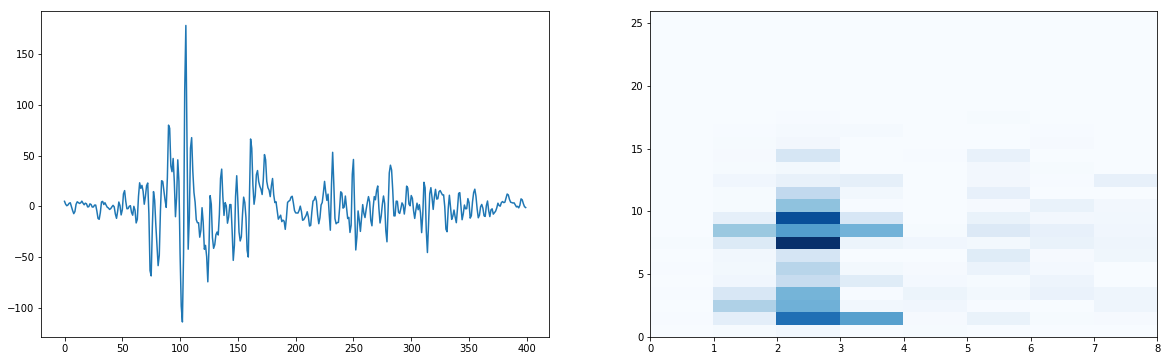

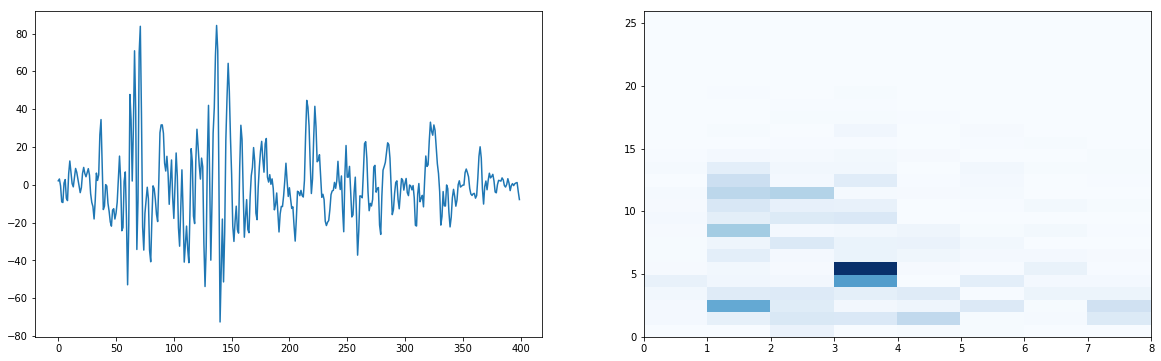

In [18]:
plot_random_spectrogram(features)